In [76]:
# !brew install graphviz
# !pip install torchviz
# !pip install scipy

/bin/bash: brew: command not found


In [7]:
import torch
from torch import nn as NN
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import torchdata

import torchvision
from torchvision import transforms as T
from torchvision.models import resnet34
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

from PIL import Image

import os
from enum import Enum
from dataclasses import dataclass, field
from typing import List

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# from torchviz import make_dot
from typing import List, Tuple
import json

import warnings
warnings.filterwarnings('ignore')

from scipy.spatial.distance import euclidean, minkowski


In [2]:
!mkdir ./processed_data_x
!mkdir ./processed_data_y

# Classes

In [3]:
@dataclass
class TrainResults:
    model_name: str
    train_losses: List[float] = field(default_factory=list)
    test_losses:  List[float] = field(default_factory=list)


# Values

In [17]:
@dataclass(frozen=True)
class Pathes:
    pairs_path: str = './class_dict_seg.xls'
    masks_path_rgb: str = './RGB_color_image_masks/'
    masks_path: str = './dataset/semantic_drone_dataset/label_images_semantic/'
    images_path: str = './dataset/semantic_drone_dataset/original_images/'
    processed_data_x_path: str = './processed_data_x/'
    processed_data_y_path: str = './processed_data_y/'


In [35]:
images_list_x = sorted(os.listdir(Pathes.images_path))
images_list_y1 = sorted(os.listdir(Pathes.masks_path))
images_list_y2 = sorted(os.listdir(Pathes.masks_path_rgb))

In [18]:
clusters = pd.read_csv(Pathes.pairs_path, index_col=0)
clusters

,r,g,b
name,,,
unlabeled,0,0,0
paved-area,128,64,128
dirt,130,76,0
grass,0,102,0
gravel,112,103,87
water,28,42,168
rocks,48,41,30
pool,0,50,89
vegetation,107,142,35


In [20]:
@dataclass(frozen=True)
class Parameters:
    batch_size: int = 512
    test_size: float = 0.2
    epochs: int = 150
    image_n_chanels: int = 3
    image_height: int=256
    image_width: int=256
    treshold_for_cluster = 0.21
    num_of_clusters: int = len(clusters)
    image_shape: Tuple[int, int] = (256, 256)

# Functions

In [22]:
def round_to_clusters(image: np.ndarray, clusters_colors: np.ndarray):
    i1 = (image).copy()
    h, w, _ = i1.shape
    for l in range(h):
        for c in range(w):
            md = np.inf
            for cc in (clusters_colors):
                d = minkowski(cc.copy(), i1[l, c].copy())
                if d < md:
#                     print(l, c, cc, i1[l, c], d)
                    md = d
                    k = cc.copy()
            i1[l, c] = k
    return (i1).astype(np.uint8)


def channels_to_clusters_spread(x: torch.Tensor) -> torch.Tensor:
    c, h, w = x.shape
    mask = torch.zeros(Parameters.num_of_clusters, h, w)
#     for i, c in enumerate(torch.from_numpy(clusters.values)):
#         p = torch.argwhere(c.view(3, 1, 1) == x)[:, 1:3]
#         mask[i, p[:, 0], p[:, 1]] = 1
    for i in range(h):
        for j in range(w):
            index = np.argwhere(np.all(clusters.values == x[:, i, j].numpy(), axis=1))
            mask[index, i, j] = 1
    return mask
            
    
        

# Process data

In [23]:
x = Image.open(Pathes.images_path + images_list_x[0]).resize(Parameters.image_shape, Image.Resampling.BOX)
y1 = Image.open(Pathes.masks_path + images_list_y1[0]).resize(Parameters.image_shape, Image.Resampling.BOX)
y2 = Image.open(Pathes.masks_path_rgb + images_list_y2[0]).resize(Parameters.image_shape, Image.Resampling.BOX)
np.array(x).shape, np.array(y1).shape, np.array(y2).shape

((256, 256, 3), (256, 256), (256, 256, 3))

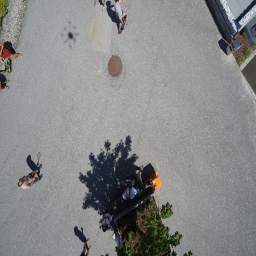

In [24]:
x

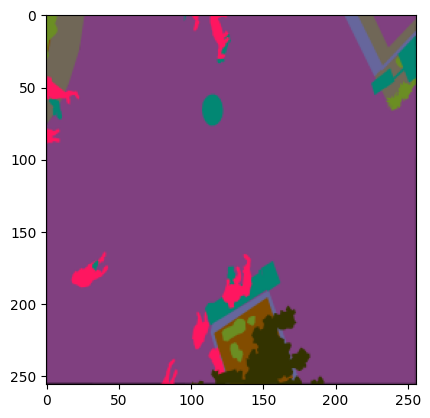

In [25]:
plt.imshow(y2)

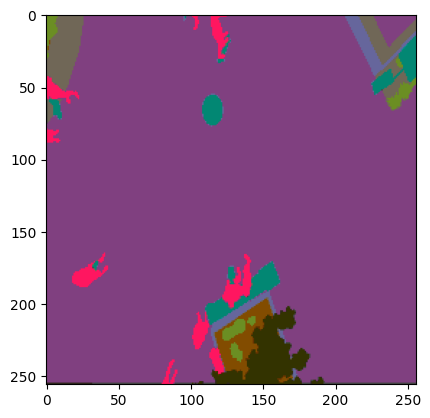

In [26]:
img_processed = round_to_clusters(np.array(y2), clusters.values)
plt.imshow(img_processed.astype(np.uint8))

In [27]:
x = np.zeros(Parameters.image_shape)
for i in clusters.values:
    x += np.all(np.array(img_processed) == i, axis=2).astype(int)
np.sum(x)

65536.0

In [182]:
256*256

65536

In [28]:
for i, (x_i, y_i) in tqdm(enumerate(zip(images_list_x, images_list_y2))):
    x = Image.open(Pathes.images_path + x_i).resize(Parameters.image_shape, Image.Resampling.BOX)
    torch.save(pil_to_tensor(x), Pathes.processed_data_x_path + str(i) + '.pt')
    
    y = Image.open(Pathes.masks_path_rgb + y_i).resize(Parameters.image_shape, Image.Resampling.BOX)
    y_r = Image.fromarray(round_to_clusters(np.array(y), clusters.values))
    y_c = channels_to_clusters_spread(pil_to_tensor(y_r))
    torch.save(y_c, Pathes.processed_data_y_path + str(i) + '.pt')
    
    

0it [00:00, ?it/s]